In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
price_raw = pd.read_excel('Daily물가지수.xlsx', sheet_name='p', skiprows=13, index_col=0).iloc[6:]
price_raw.index = pd.to_datetime(price_raw.index)

In [3]:
target = pd.read_excel('Daily물가지수.xlsx', sheet_name='inputML', index_col=0)

In [4]:
target = target.loc[:, 'CPId']

In [5]:
company_list = ['MSFT', 'GOOG', 'META',
                'BRK.B', 'JPM', 'BAC',
                'LLY', 'JNJ', 'ABBV',
                'PG', 'KO', 'PM',
                'AAPL', 'NVDA', 'CSCO',
                'AMZN', 'WMT', 'COST',
                'XOM', 'CVX', 'COP',
                'NEE', 'SO', 'DUK',
                'TSLA', 'GM', 'DHI',
                'UNH', 'HCA', 'CI',
                'LIN', 'SHW', 'ECL',
                'TMUS', 'T', 'VZ',
                'MCD', 'DIS', 'BKNG',
                'FDX', 'UNP', 'UPS',
                'MCK', 'COR', 'GWW',
                'WM', 'RSG', 'WMB',
                'FCX', 'NEM', 'VMC']

In [6]:
cp_list = [i+'-US' for i in company_list]

In [7]:
ret = price_raw.loc[:, cp_list].pct_change(5)

C:\Users\USER\AppData\Local\Temp\ipykernel_5616\4257273360.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ret = price_raw.loc[:, cp_list].pct_change(5)


In [8]:
input_df = ret.loc[target.index].dropna()

In [9]:
target_df = target.loc[input_df.index]

### Exp 3.
실험 목적: Daily CPI Fitting  
  
Input data:
1. 20일 수익률 사용, Not Moving Avg

2. <b>CPI(DATA-2일 Lagging, Target data): CPI를 2일 래깅하므로 2틀 후 데이터를 맞출 수 있나 확인 가능.</b>

1. 데이터 준비:
- input_df와 target_df를 병합해 하나의 다변량 DataFrame(data)로 만듦.
- VAR은 다변량 시계열을 처리하므로 CPI와 주가를 함께 입력.
2. VAR 모델:
- VAR를 사용해 주가와 CPI 간의 관계를 학습.
- maxlags=10으로 설정하고, ic='aic'로 최적 시차를 자동 선택.
- 1일 예측(steps=1)을 수행해 CPI 값을 추출.
3. GARCH 모델:
- VAR의 CPI 잔차에 GARCH(1,1)을 적용해 변동성을 추정.
- mean='Zero': 잔차의 평균을 0으로 가정.
- 예측값에 변동성을 추가해 보정.
4. Walk-Forward 예측:
- 2020-01-01부터 매일 과거 데이터를 사용해 다음 날을 예측.
- forecast_input으로 최근 lags 만큼 데이터를 제공.
5. 결과 저장 및 시각화:
- 예측값과 실제값을 results_df에 저장하고 CSV로 내보냄.
- 실제 CPI와 예측 CPI를 그래프로 비교.
- MAE(평균 절대 오차)로 성능 평가.

In [11]:
from statsmodels.tsa.vector_ar.var_model import VAR
from arch import arch_model
from sklearn.decomposition import PCA

In [12]:
n_pca_comp = 5
pca = PCA(n_components=n_pca_comp)

In [13]:
reduced_input = pca.fit_transform(input_df)

In [14]:
reduced_df = pd.DataFrame(reduced_input, index=input_df.index, columns=[f'PC{i+1}' for i in range(n_pca_comp)])

In [15]:
target_df = target_df.shift(2)

In [17]:
# 데이터 병합 (VAR는 다변량 데이터를 요구하므로 주가와 CPI를 하나의 DataFrame으로)
data = pd.concat([target_df, reduced_df], axis=1).dropna()
data.index.freq = 'B'

In [21]:
# 3. 단일 VAR 모델 학습 (2020-01-01 이전 데이터로)
start_date = '2020-01-01'
start_idx = data.index.get_loc(start_date)

train_data = data.iloc[:start_idx]
train_data.index.freq = 'B'
lags = 5  # 시차 축소

var_model = VAR(train_data, freq='B')
try:
    var_results = var_model.fit(maxlags=lags)
except Exception as e:
    print(f"VAR fitting failed: {e}")
    exit()

# 4. 예측 루프 (단일 모델로 예측 반복)
predictions = []
actuals = []
dates = []

for i in range(start_idx, len(data)):
    # 예측에 필요한 과거 데이터
    forecast_input = data.values[i-lags:i]
    var_forecast = var_results.forecast(forecast_input, steps=1)
    cpi_pred = var_forecast[0, 0]

    # 간단한 변동성 보정 (잔차의 표준편차 사용)
    residuals = var_results.resid['CPId']
    vol = residuals.std()
    cpi_pred_adjusted = cpi_pred + np.random.normal(0, vol)

    actual_value = data['CPId'].iloc[i]
    pred_date = data.index[i]

    # 결과 저장
    predictions.append(cpi_pred_adjusted)
    actuals.append(actual_value)
    dates.append(pred_date)

    print(f"Date: {pred_date}, Predicted CPI: {cpi_pred_adjusted:.6f}, Actual CPI: {actual_value:.6f}")

Date: 2020-01-01 00:00:00, Predicted CPI: 2.293802, Actual CPI: 2.302438
Date: 2020-01-02 00:00:00, Predicted CPI: 2.297829, Actual CPI: 2.301225
Date: 2020-01-03 00:00:00, Predicted CPI: 2.293401, Actual CPI: 2.321242
Date: 2020-01-06 00:00:00, Predicted CPI: 2.335976, Actual CPI: 2.339955
Date: 2020-01-07 00:00:00, Predicted CPI: 2.368406, Actual CPI: 2.364286
Date: 2020-01-08 00:00:00, Predicted CPI: 2.392538, Actual CPI: 2.384503
Date: 2020-01-09 00:00:00, Predicted CPI: 2.397802, Actual CPI: 2.402627
Date: 2020-01-10 00:00:00, Predicted CPI: 2.410598, Actual CPI: 2.417699
Date: 2020-01-13 00:00:00, Predicted CPI: 2.417850, Actual CPI: 2.436682
Date: 2020-01-14 00:00:00, Predicted CPI: 2.446835, Actual CPI: 2.455744
Date: 2020-01-15 00:00:00, Predicted CPI: 2.467132, Actual CPI: 2.474183
Date: 2020-01-16 00:00:00, Predicted CPI: 2.482784, Actual CPI: 2.494441
Date: 2020-01-17 00:00:00, Predicted CPI: 2.517563, Actual CPI: 2.493720
Date: 2020-01-20 00:00:00, Predicted CPI: 2.478076,

In [22]:
# 5. 결과 DataFrame 생성 및 저장
results_df = pd.DataFrame({
    'Date': dates,
    'Actual_CPI': actuals,
    'Predicted_CPI': predictions
}).set_index('Date')

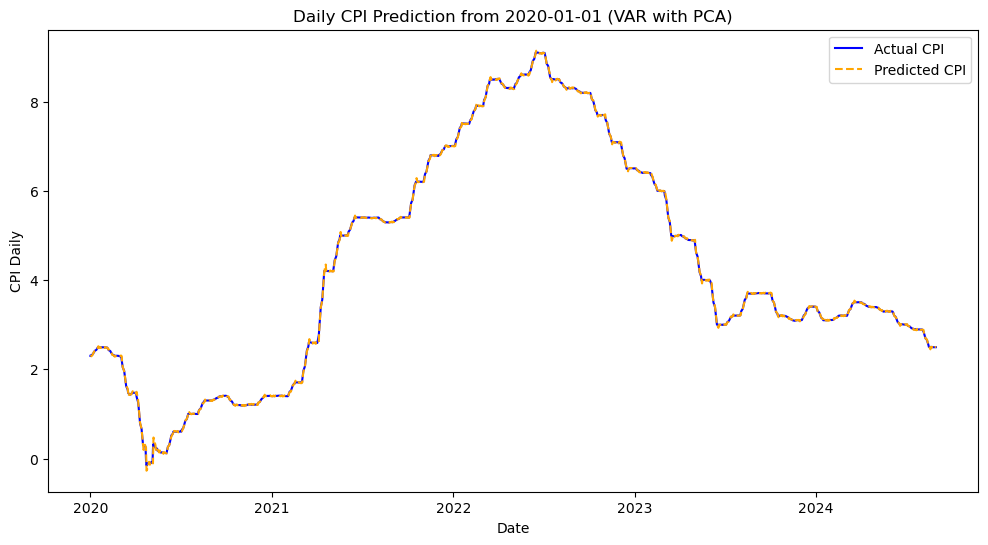

Mean Absolute Error (MAE): 0.012432


In [23]:
# 6. 시각화
plt.figure(figsize=(12, 6))
plt.plot(results_df.index, results_df['Actual_CPI'], label='Actual CPI', color='blue')
plt.plot(results_df.index, results_df['Predicted_CPI'], label='Predicted CPI', linestyle='--', color='orange')
plt.legend()
plt.title('Daily CPI Prediction from 2020-01-01 (VAR with PCA)')
plt.xlabel('Date')
plt.ylabel('CPI Daily')
plt.show()

# 7. 성능 평가 (MAE)
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(results_df['Actual_CPI'], results_df['Predicted_CPI'])
print(f"Mean Absolute Error (MAE): {mae:.6f}")

In [24]:
# Naive 예측: 이전 날짜 값을 그대로 사용
naive_pred = data['CPId'].shift(1).iloc[start_idx:]
naive_actual = data['CPId'].iloc[start_idx:]
mae_naive = np.mean(np.abs(naive_pred - naive_actual))
print(f"Naive MAE: {mae_naive:.6f}")

Naive MAE: 0.020339


In [25]:
print(f"CPI 표준편차: {data['CPId'].std():.6f}")
print(f"CPI 표준편차*0.2~0.3: {data['CPId'].std()*0.2:.6f}")

CPI 표준편차: 2.319335
CPI 표준편차*0.2~0.3: 0.463867


In [29]:
results_df

,Actual_CPI,Predicted_CPI
Date,,
2020-01-01,2.302438,2.293802
2020-01-02,2.301225,2.297829
2020-01-03,2.321242,2.293401
2020-01-06,2.339955,2.335976
2020-01-07,2.364286,2.368406
...,...,...
2024-08-26,2.495949,2.492988
2024-08-27,2.497589,2.503235
2024-08-28,2.496860,2.480414


In [31]:
tmp = pd.read_csv("CPI_TEMP.CSV", index_col=0)

In [33]:
tmp.index = pd.to_datetime(tmp.index)

In [35]:
pd.concat([tmp, results_df], axis=1).to_excel("TMP.xlsx")